# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

In [3]:
# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

Load feature names.

In [4]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

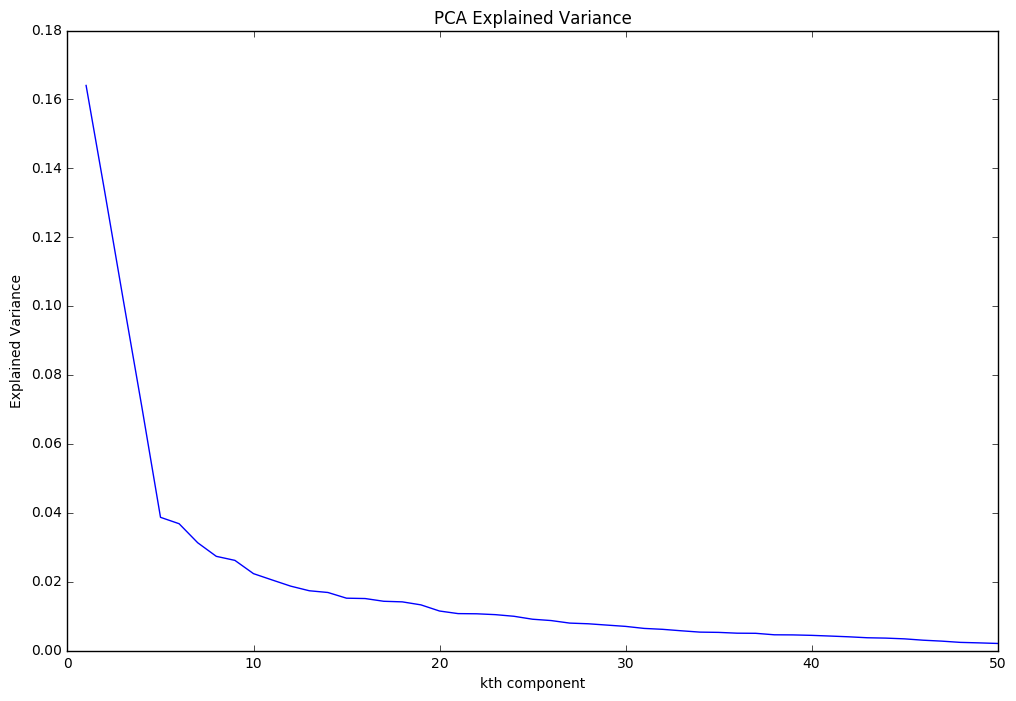

In [8]:
def P1():
### STUDENT START ###
    # Fit PCA model
    pca_mod = PCA()
    pca_mod.fit(train_data)
    # Plot explained variance of first 50 componenets
    plt.figure(figsize = (12,8))
    plt.plot(range(1,51), pca_mod.explained_variance_ratio_[:50])
    plt.xlabel("kth component")
    plt.ylabel("Explained Variance")
    plt.title("PCA Explained Variance")
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

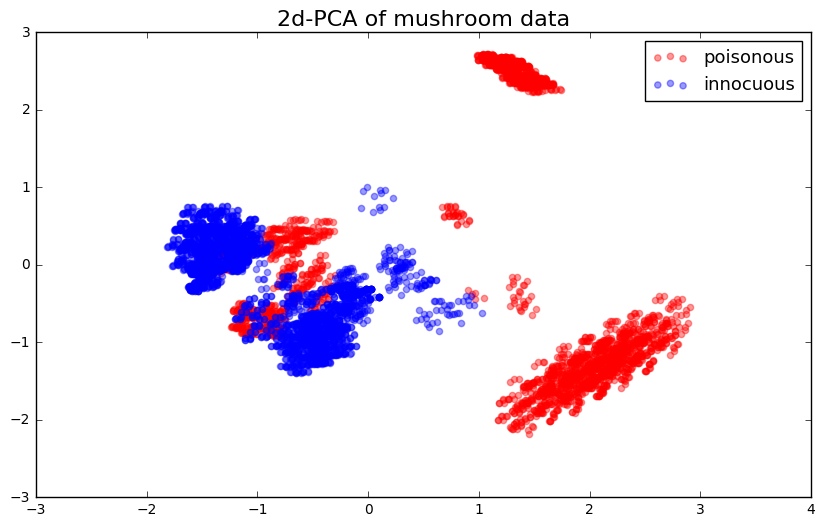

In [9]:
def P2():
    
### STUDENT START ###

    # Fit and transform data to 2d
    pca_2_mod = PCA(n_components=2)
    pca_2_mod_train = pca_2_mod.fit_transform(train_data)

    # Ploting figure
    fig, ax = plt.subplots(1, figsize=(10,6))

    ax.scatter(pca_2_mod_train[train_labels==1, 0], pca_2_mod_train[train_labels==1, 1],
               label='poisonous', color='red', alpha=.4)
    ax.scatter(pca_2_mod_train[train_labels==0, 0], pca_2_mod_train[train_labels==0, 1],
               label='innocuous', color='blue', alpha=.4)
    ax.legend(loc='best', fontsize=13)
    ax.set_title('2d-PCA of mushroom data', fontsize=16)

    plt.show()
    
    return pca_2_mod_train, pca_2_mod

### STUDENT END ###

pca_2_mod_train, pca_2_mod = P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

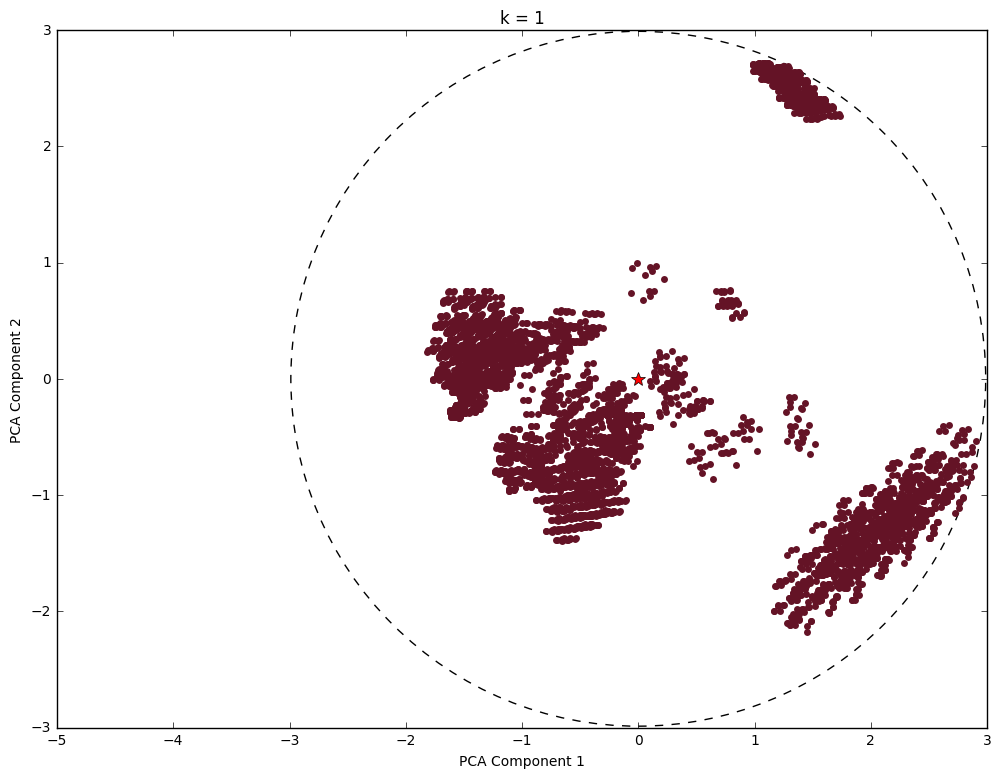

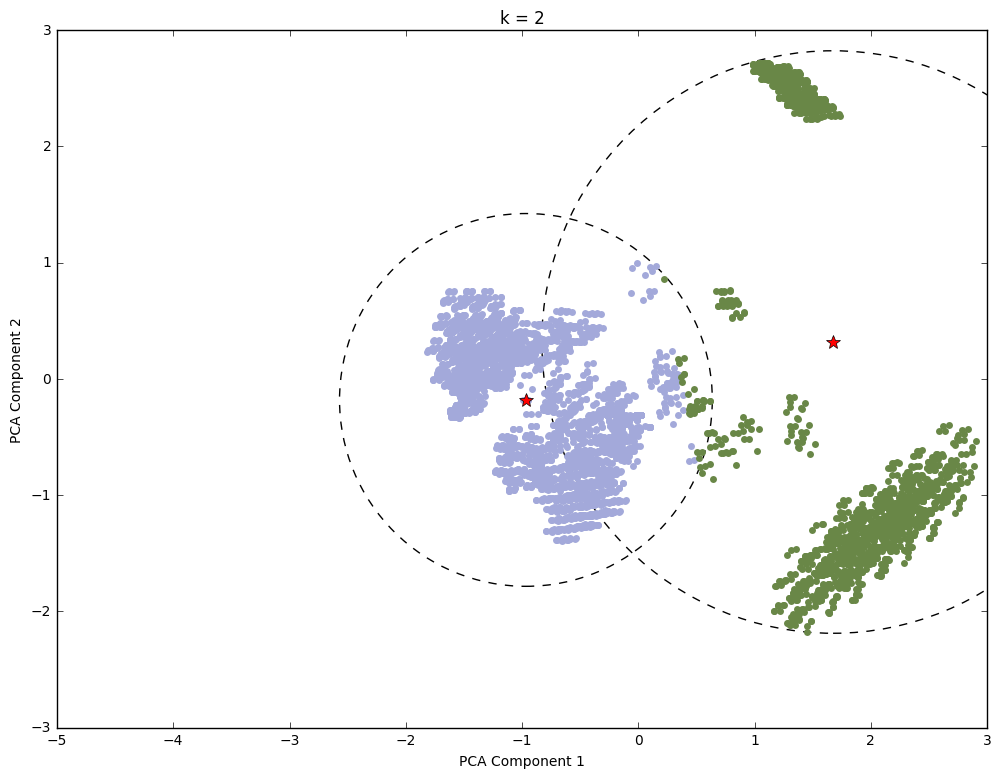

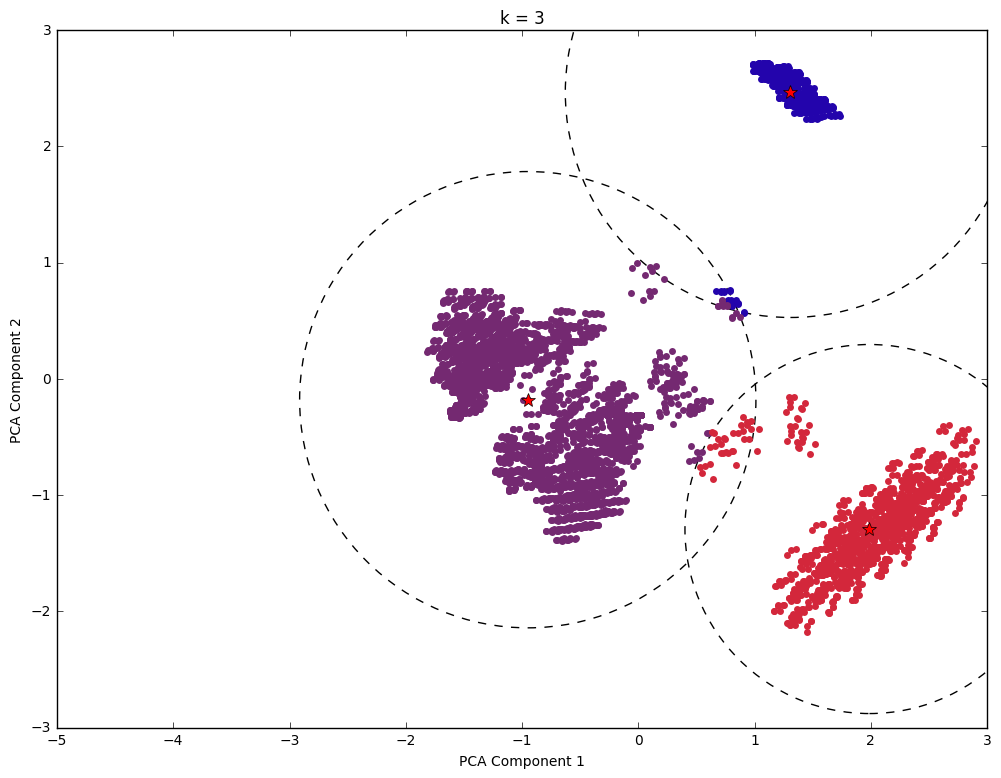

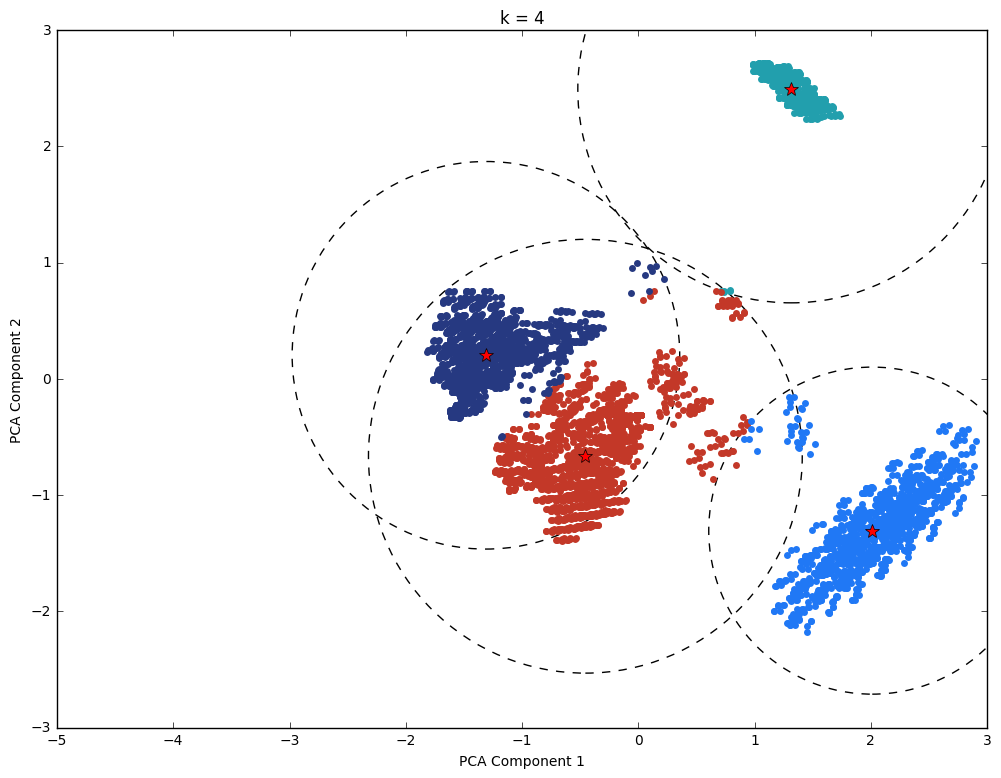

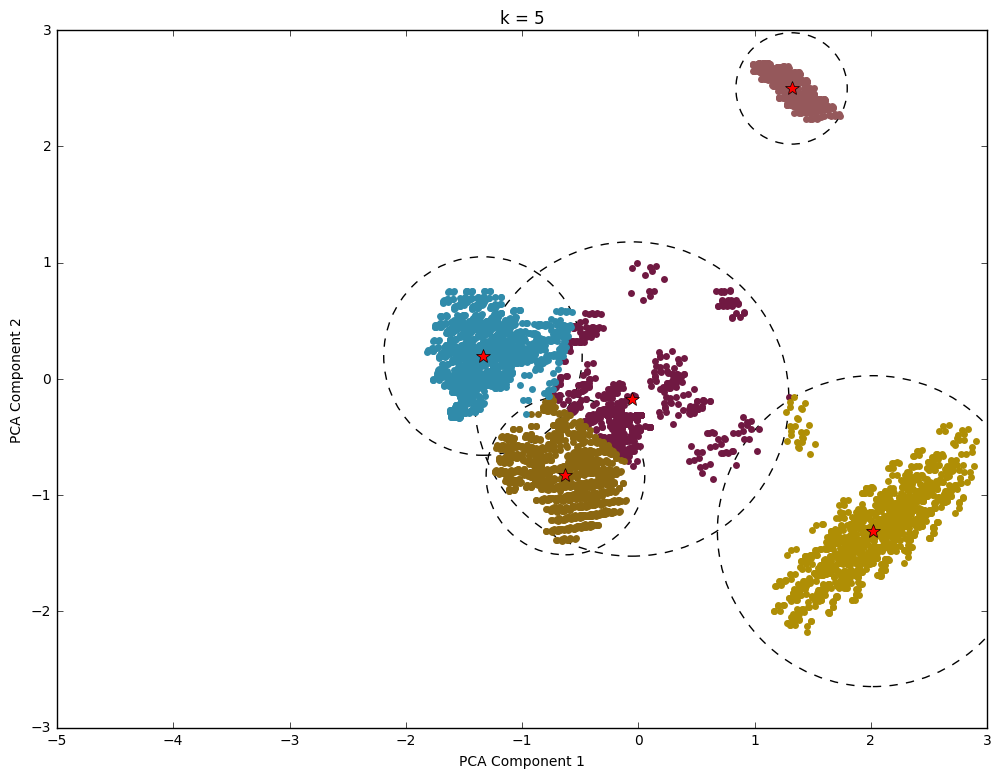

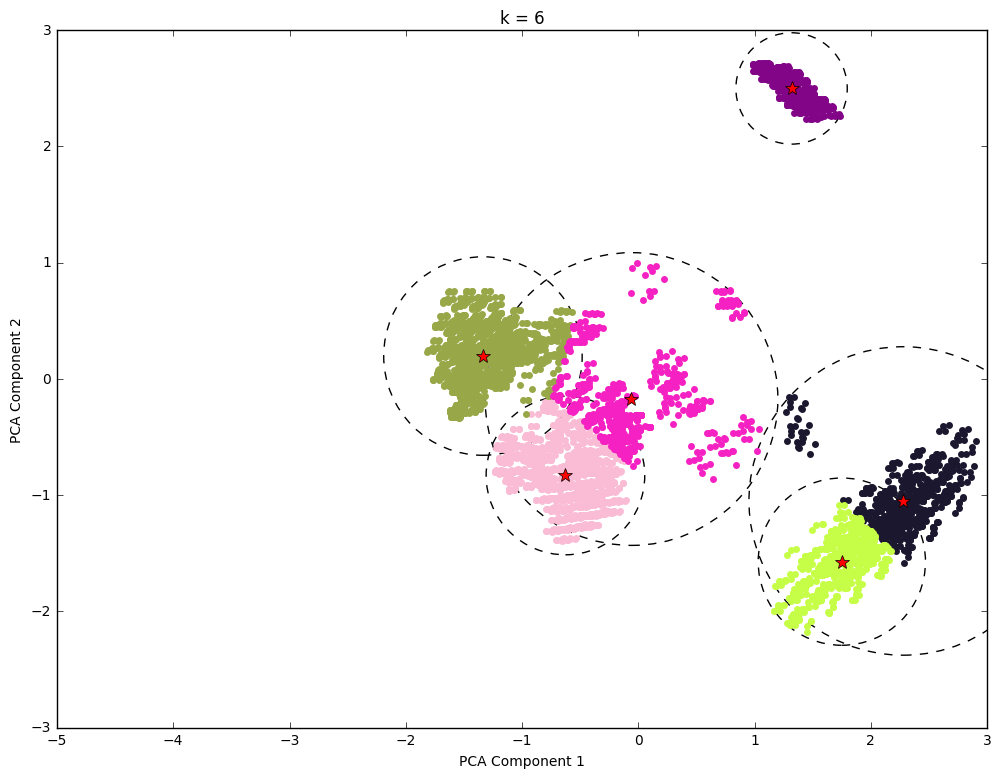

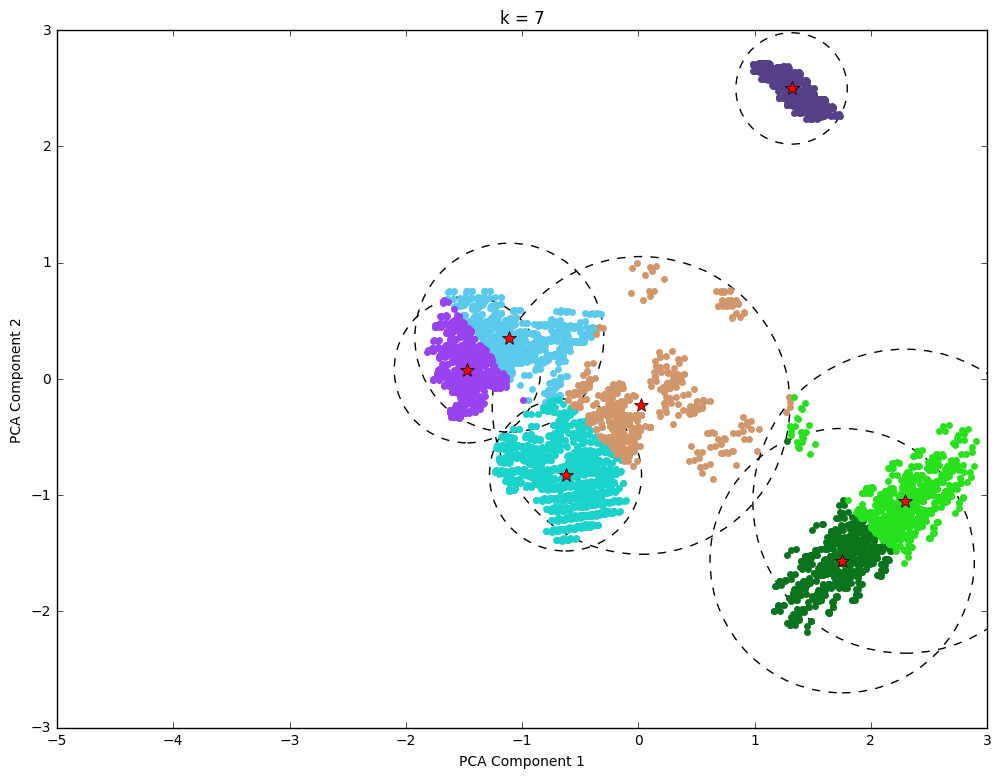

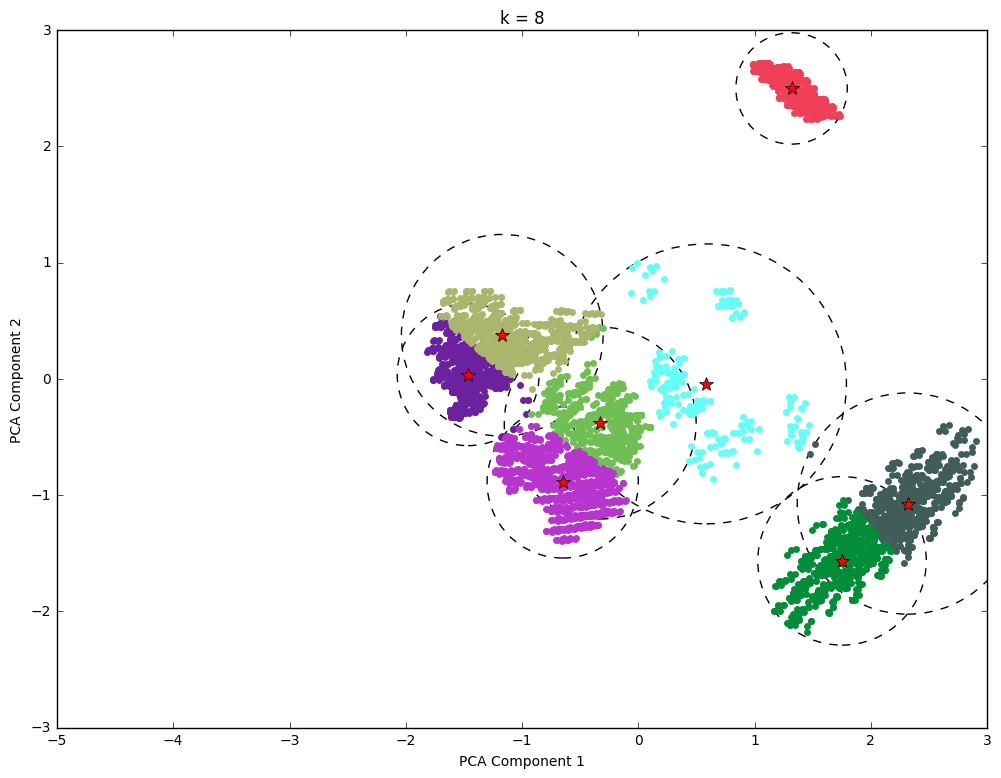

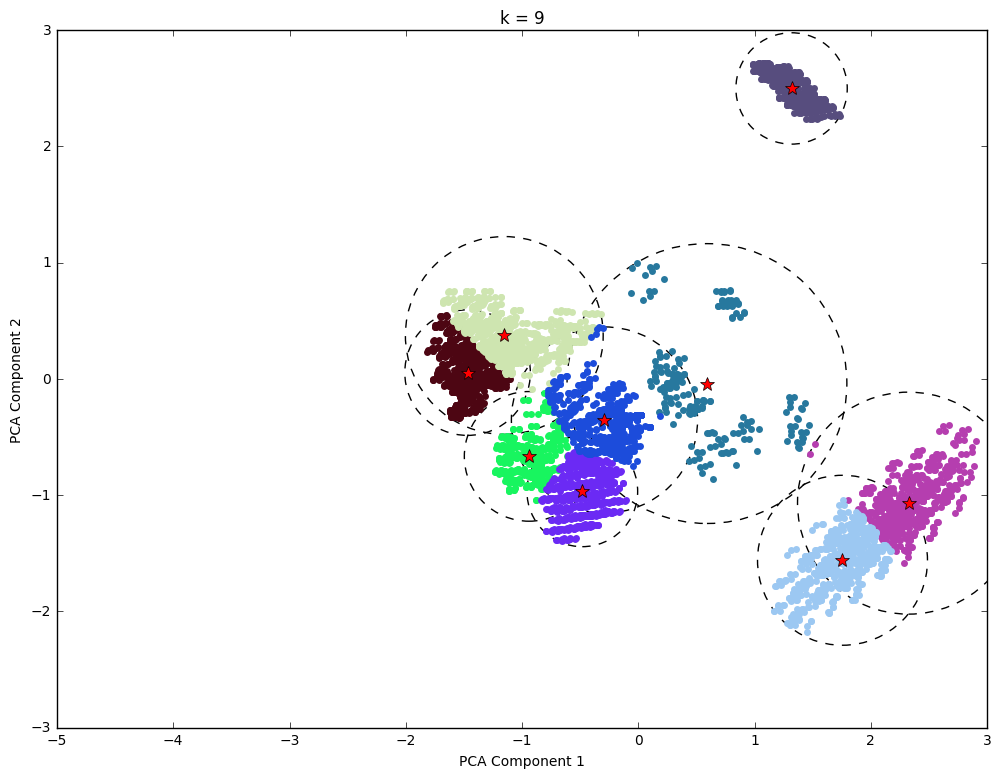

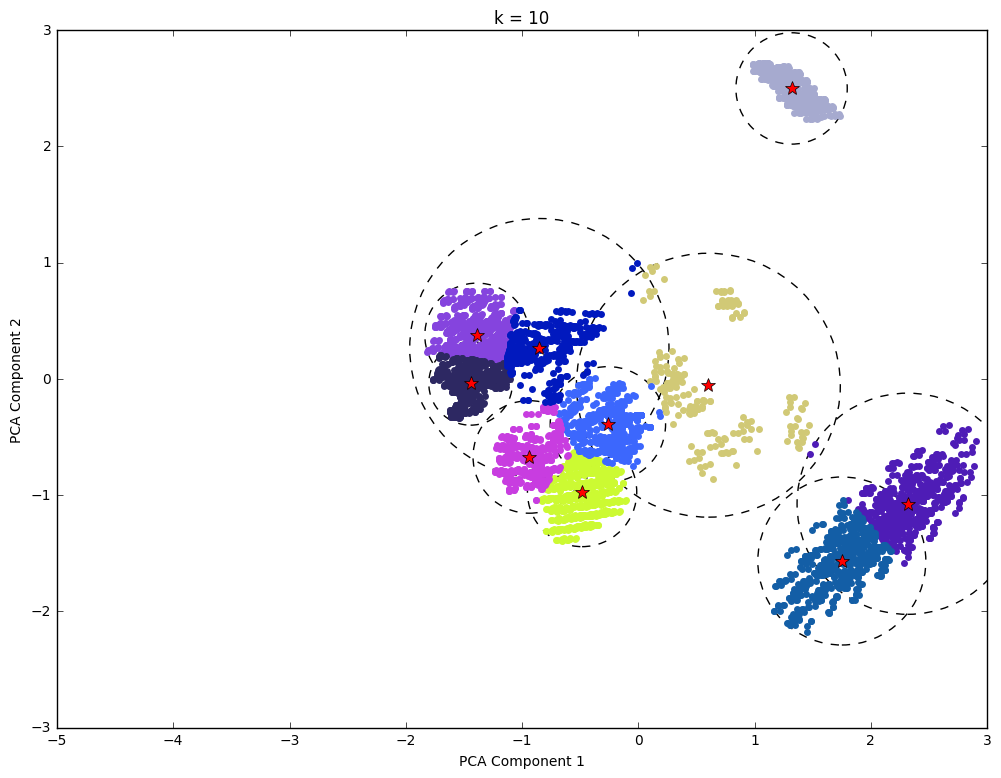

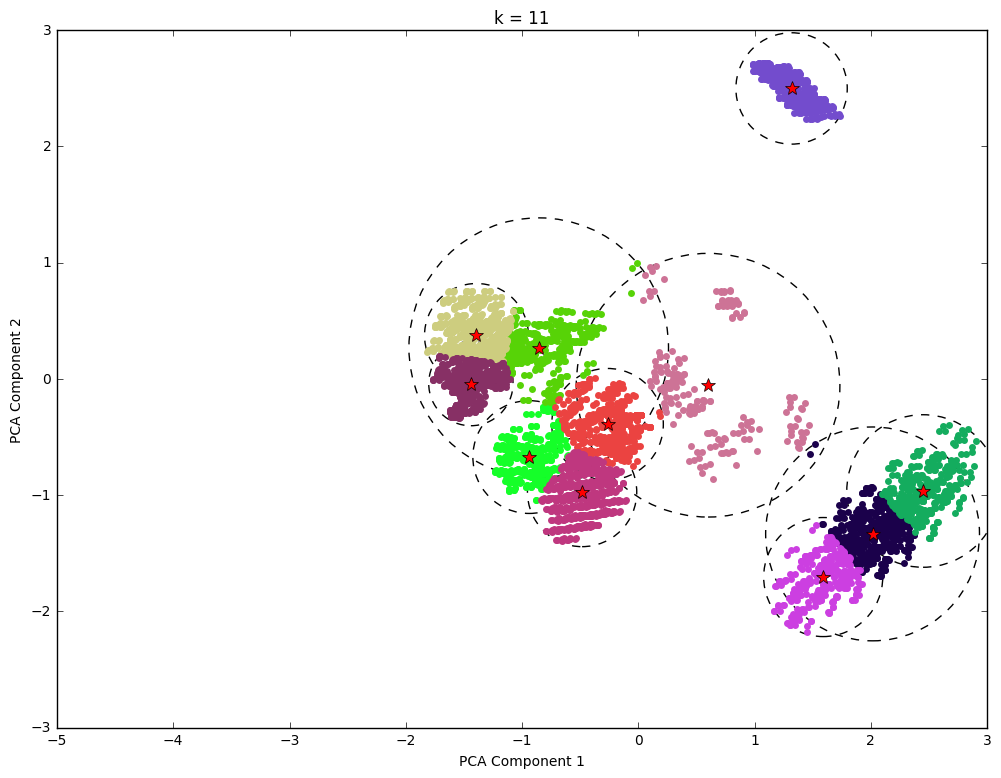

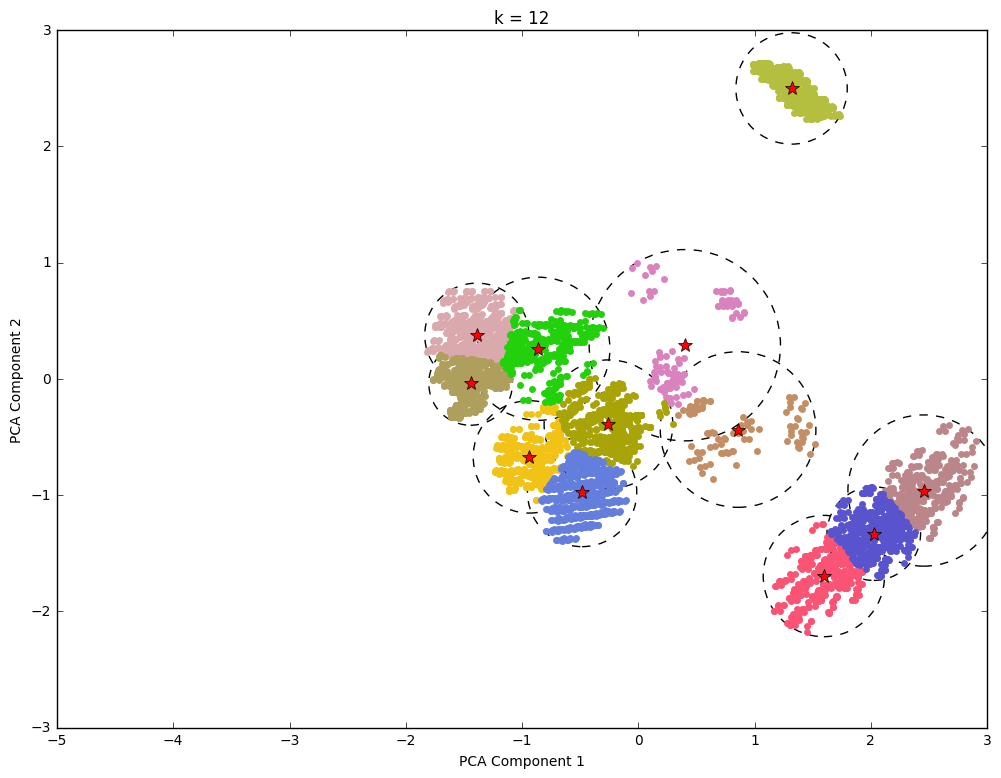

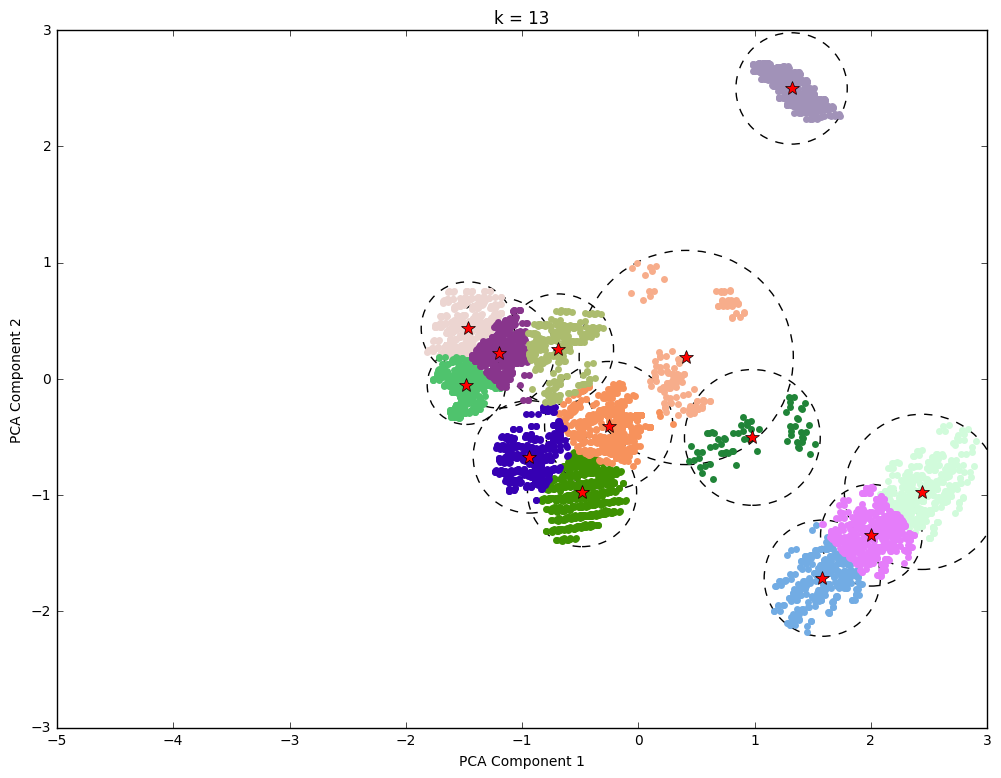

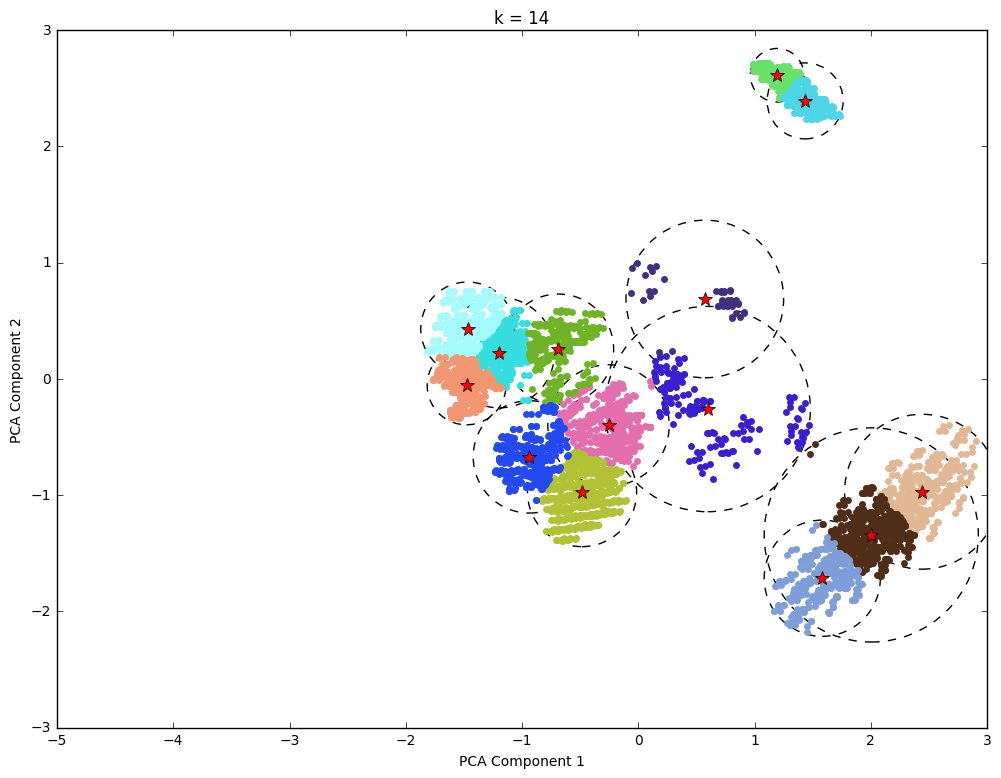

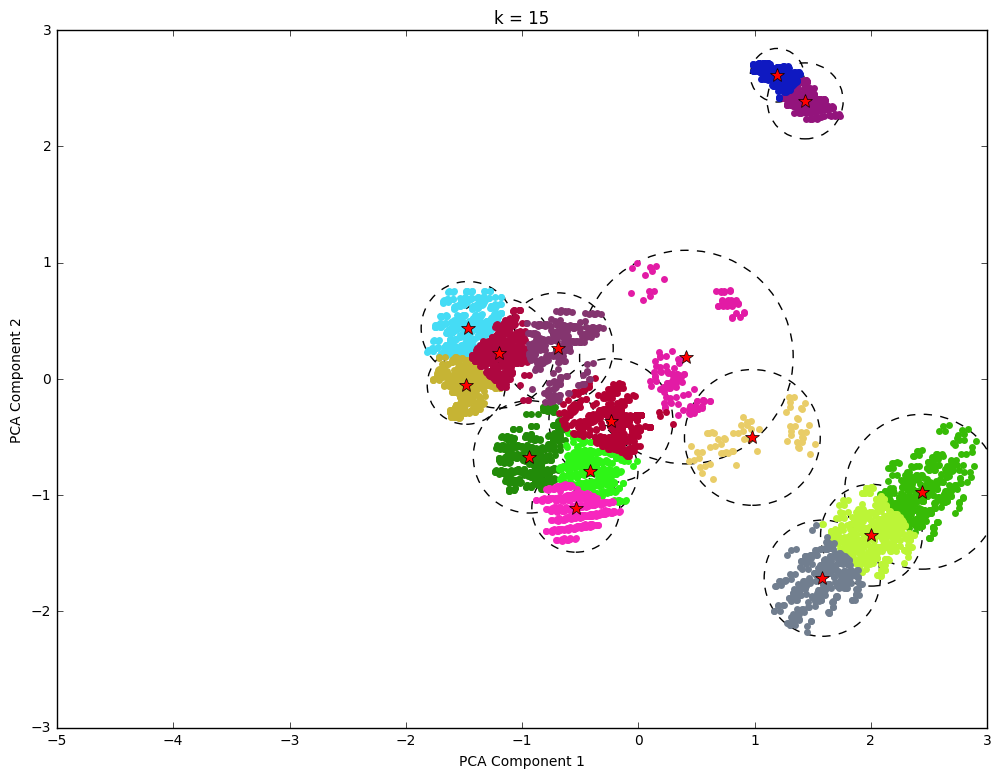

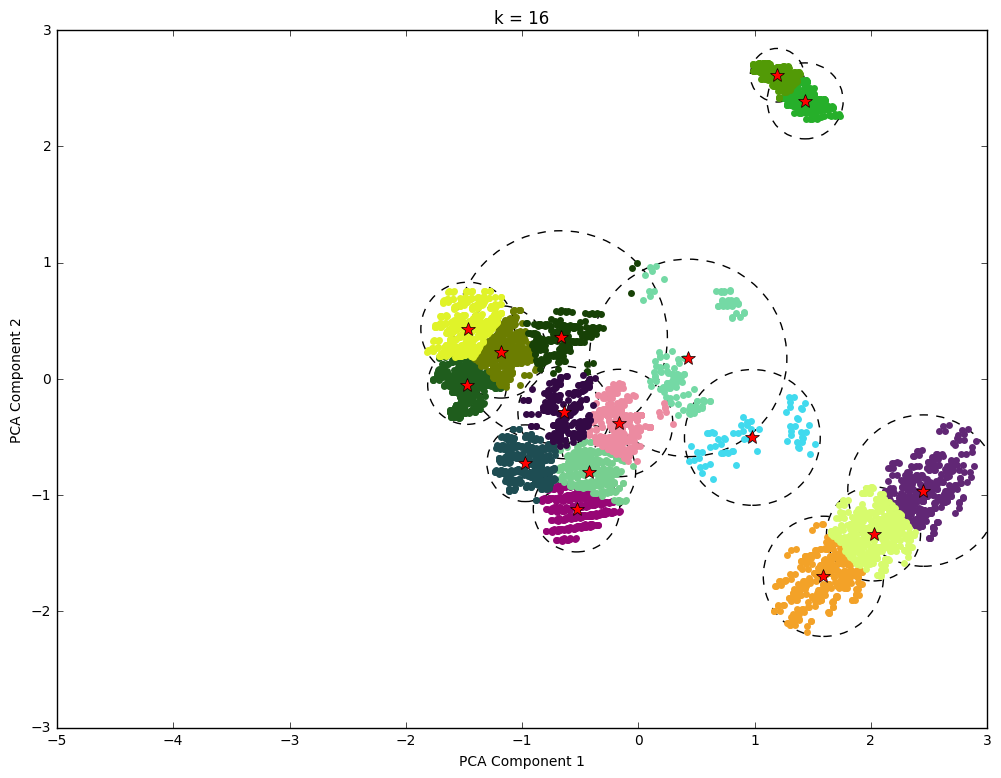

In [10]:
def P3():
### STUDENT START ###
    # Recreate 2d model
    pca_2_mod = PCA(n_components=2)
    pca_2_mod_train = pca_2_mod.fit_transform(train_data)
    
    # For n_clusters from 1 to 16
    
    for k in range(1,17):
        km_model = KMeans(n_clusters=k)
        km_model.fit(pca_2_mod_train)
        
        # Calculate distance between each data point and centroid
        
        dist = km_model.transform(pca_2_mod_train)

        # Setting up the plot
        
        plt.figure(figsize = (12,9))
        plt.axis([-5,3,-3,3])

        # Iterate over each cluster center
        for index, center in enumerate(km_model.cluster_centers_):
            # Plot associated points in each cluster with a random RGB color
            plt.plot(pca_2_mod_train[:,0][km_model.labels_==index], pca_2_mod_train[:,1][km_model.labels_==index], 
                     color = np.random.rand(3,1), ls='None', marker='o', markersize=5, markeredgewidth=0)
            # Red star will be the cluster center
            plt.plot(center[0], center[1], 'r*', markersize=10)
            # Subset distance of points that correspond to the current center
            center_subset = dist[km_model.labels_==index]
            # Find maximium distance
            max_dist = np.amax(center_subset[:, index])        
            # Plot circle with radius of max_dist around cluster center
            circle = plt.Circle(center, max_dist, fill=False, ls='dashed')
            plt.gca().add_patch(circle)

        # Labels and legends
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend(frameon=False, numpoints=1)
        plt.title("k = " + str(k))
    
### STUDENT END ###
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

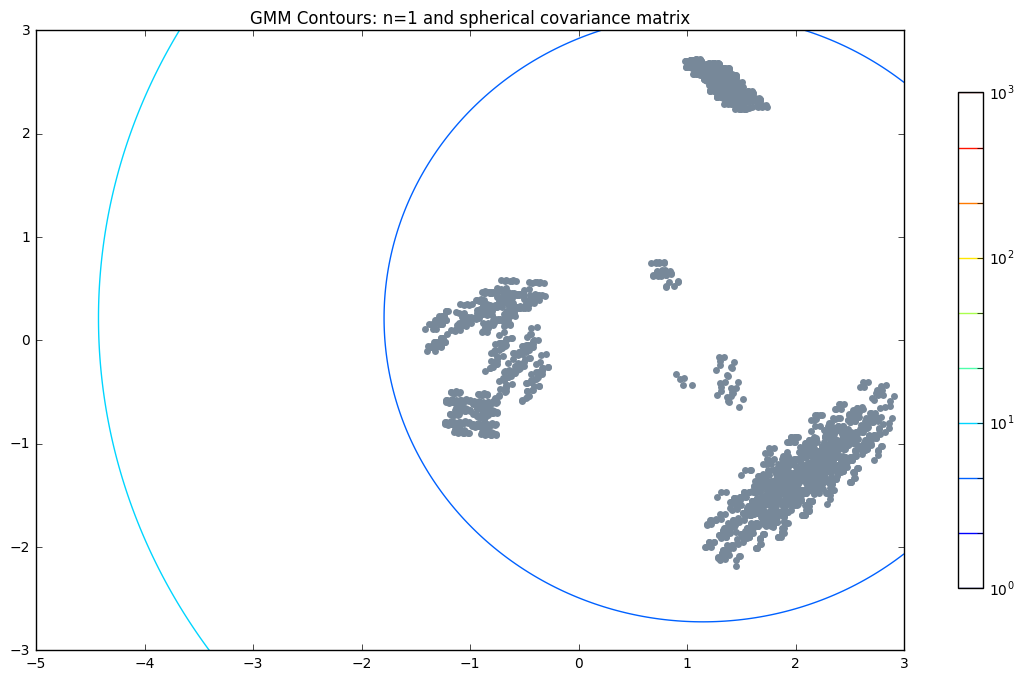

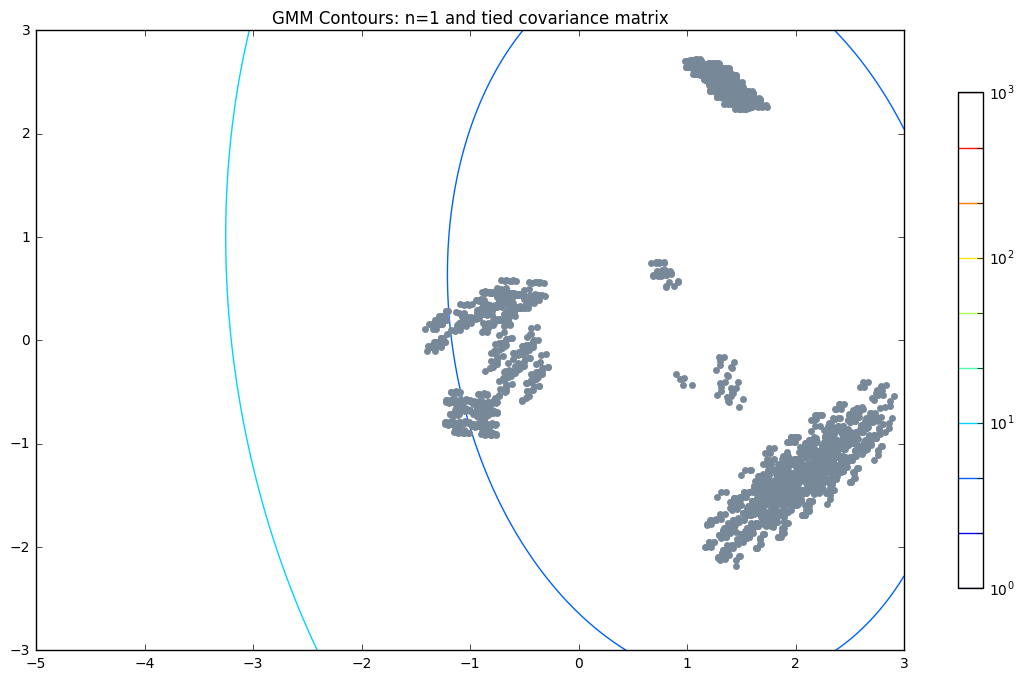

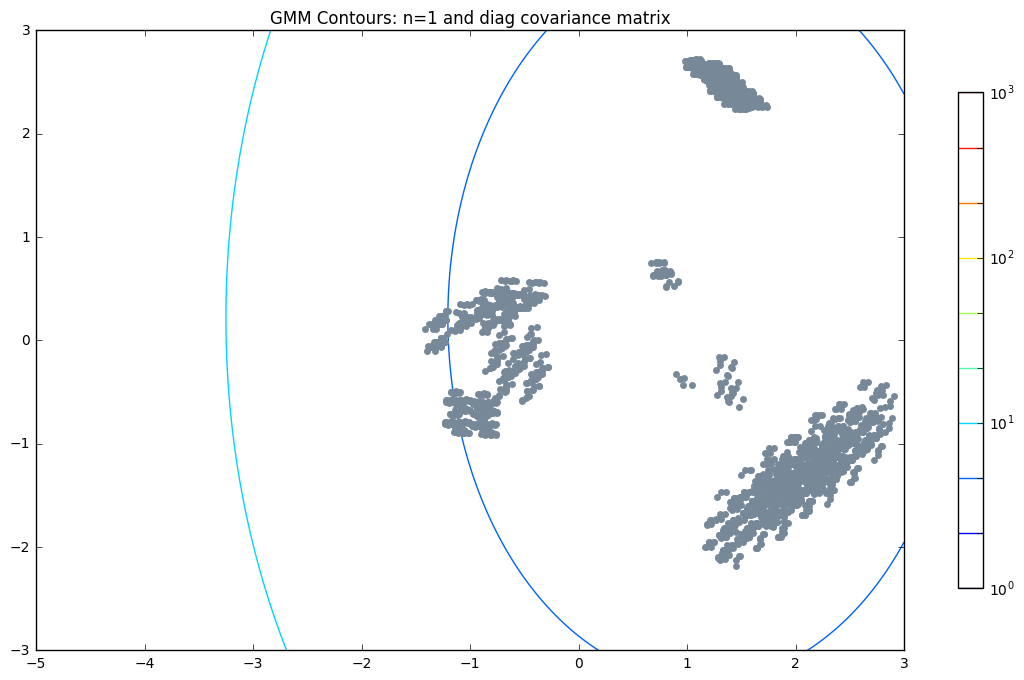

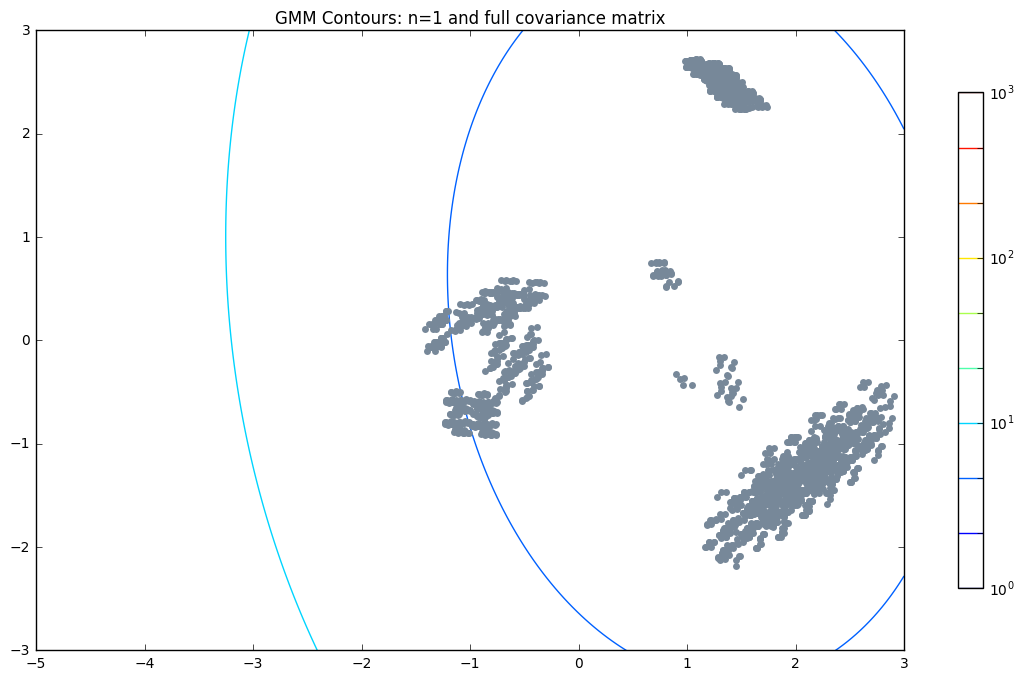

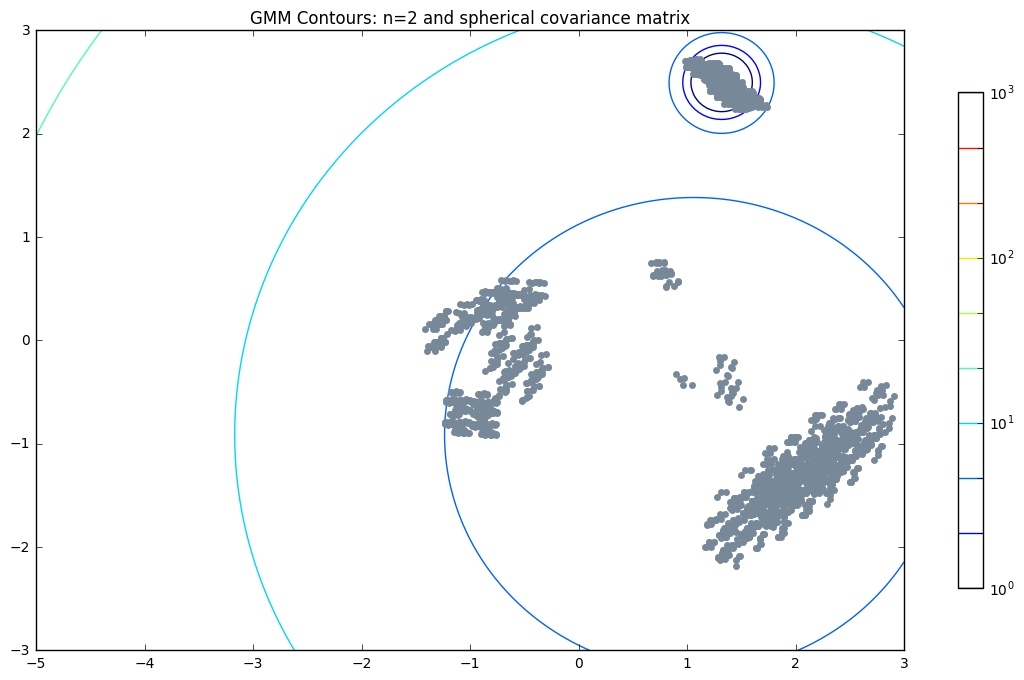

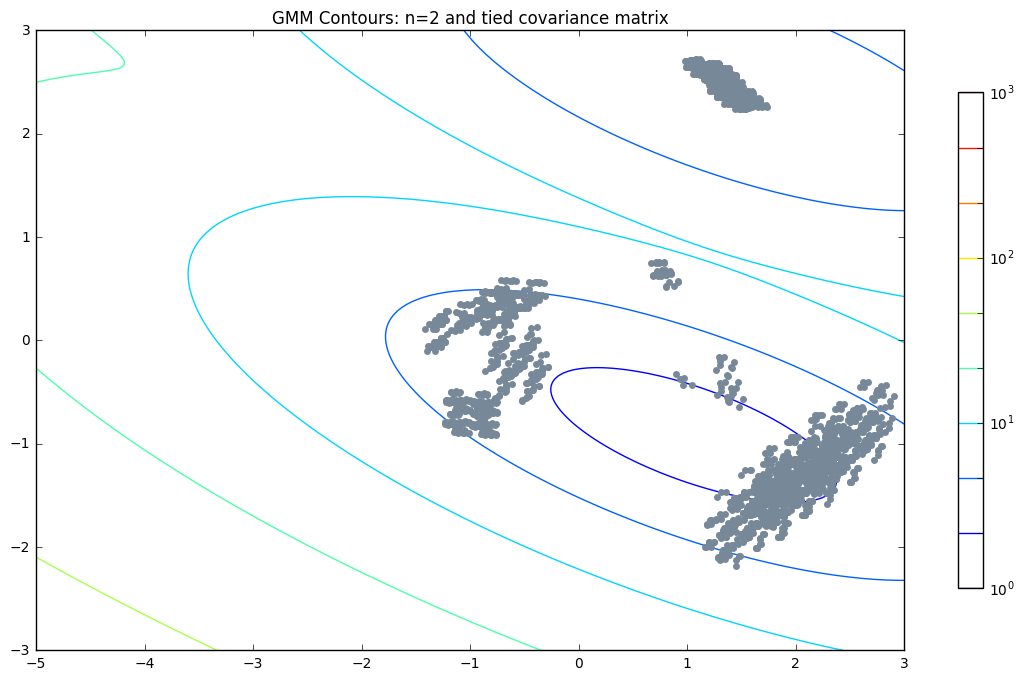

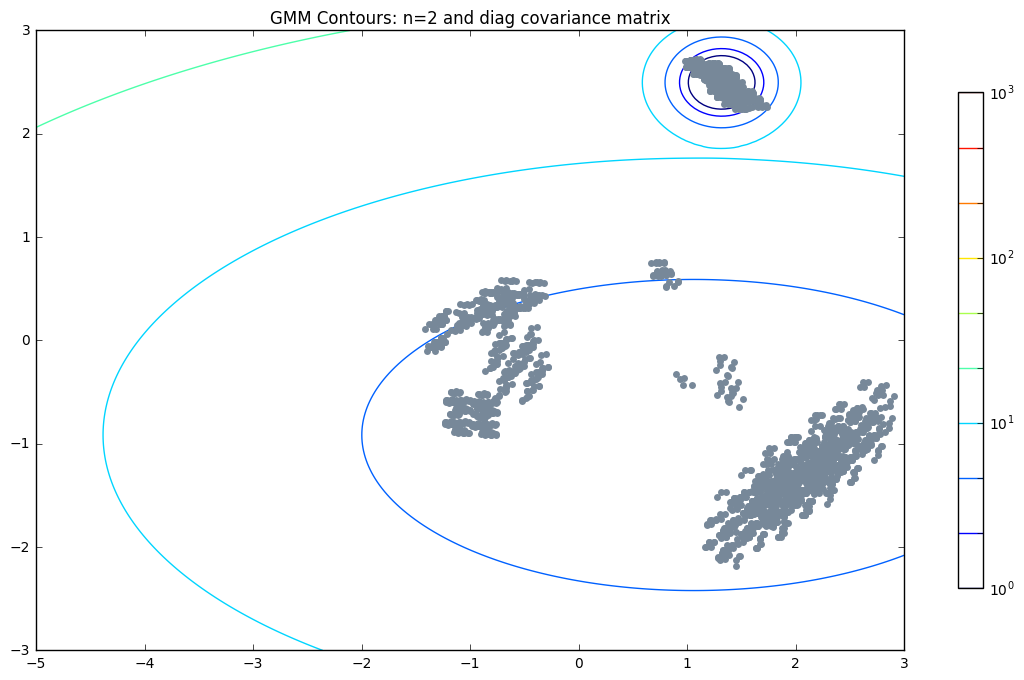

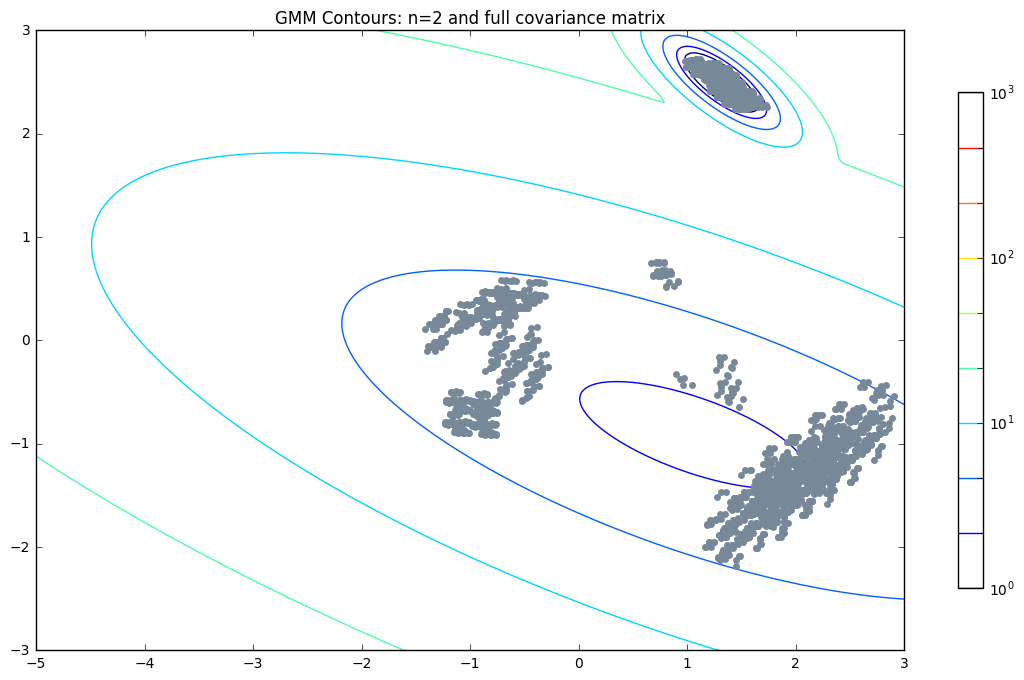

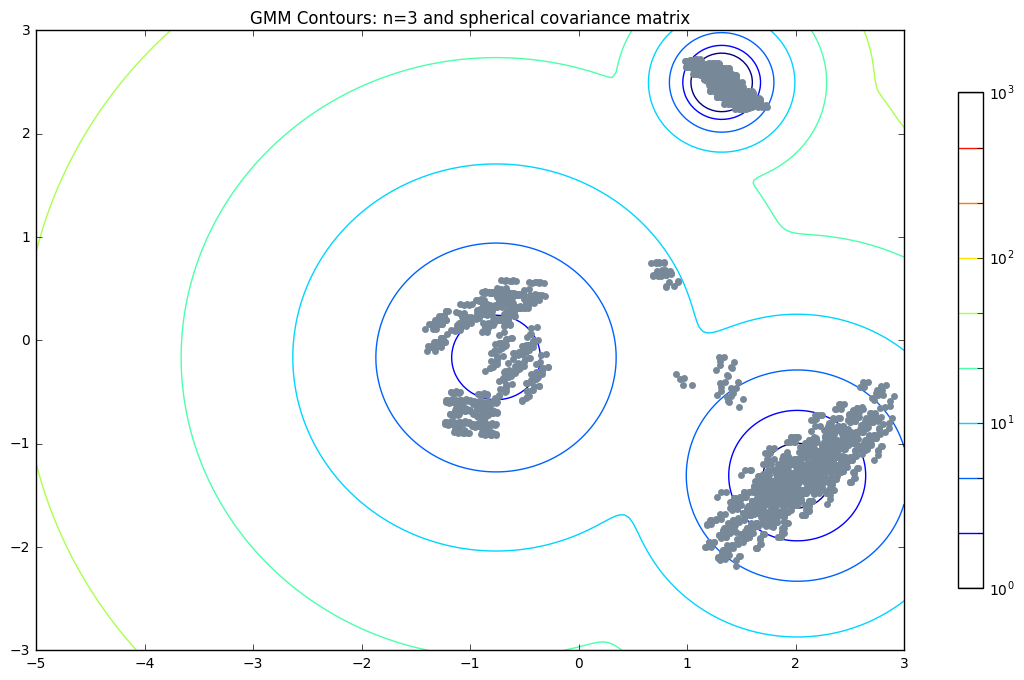

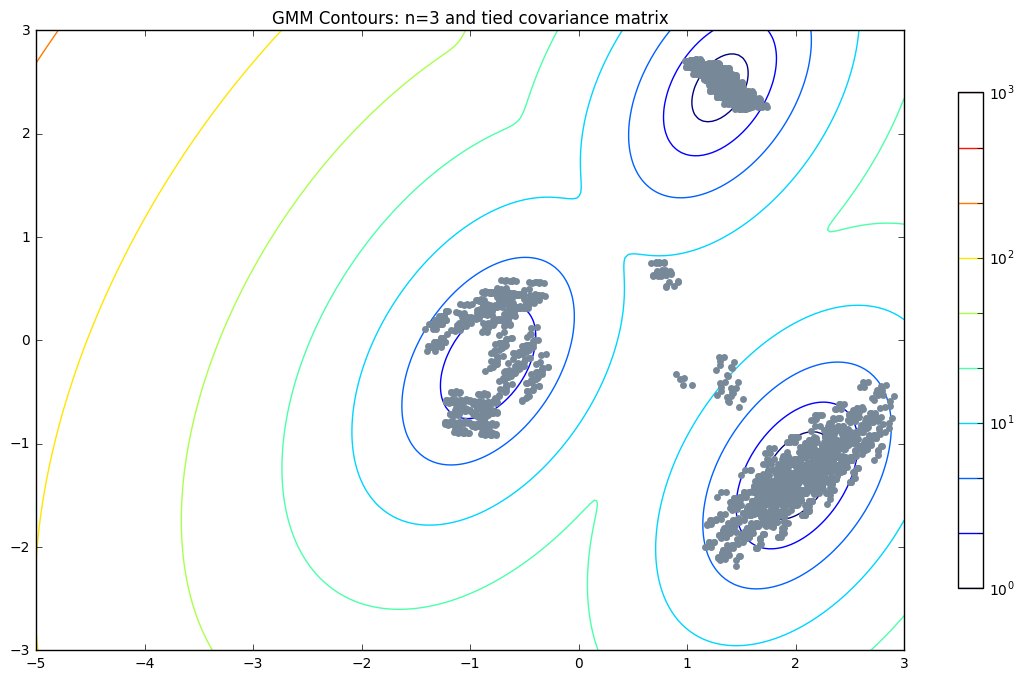

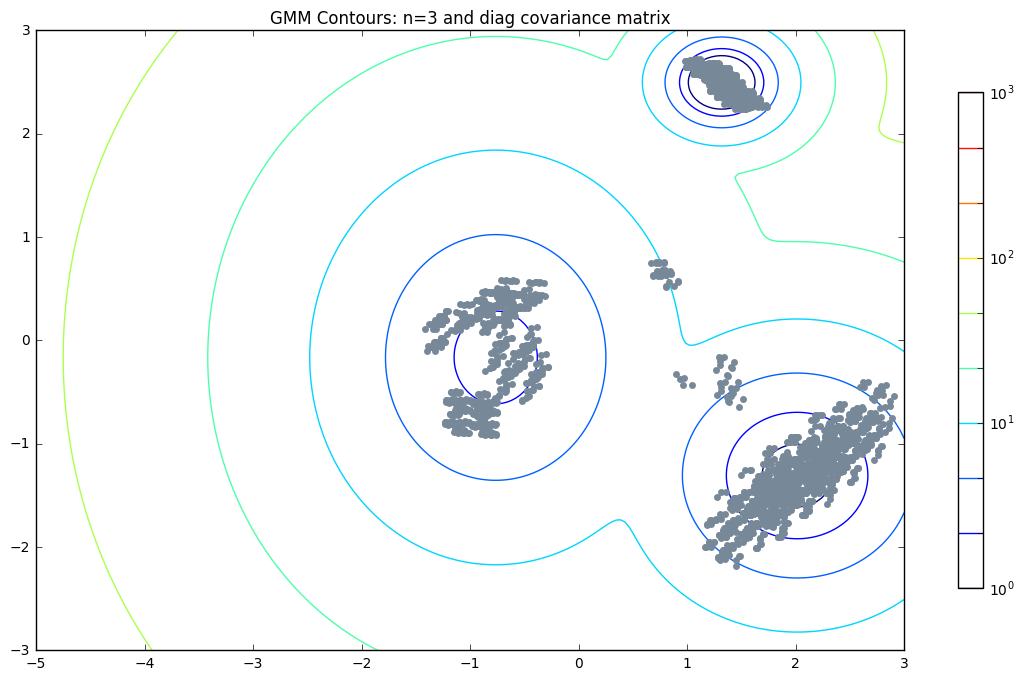

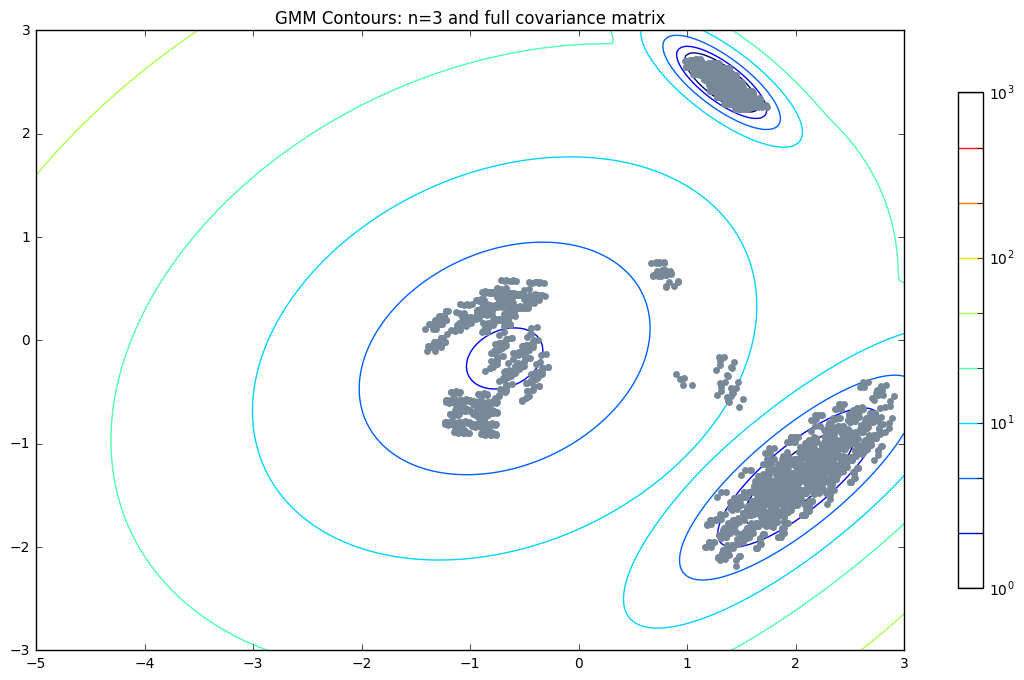

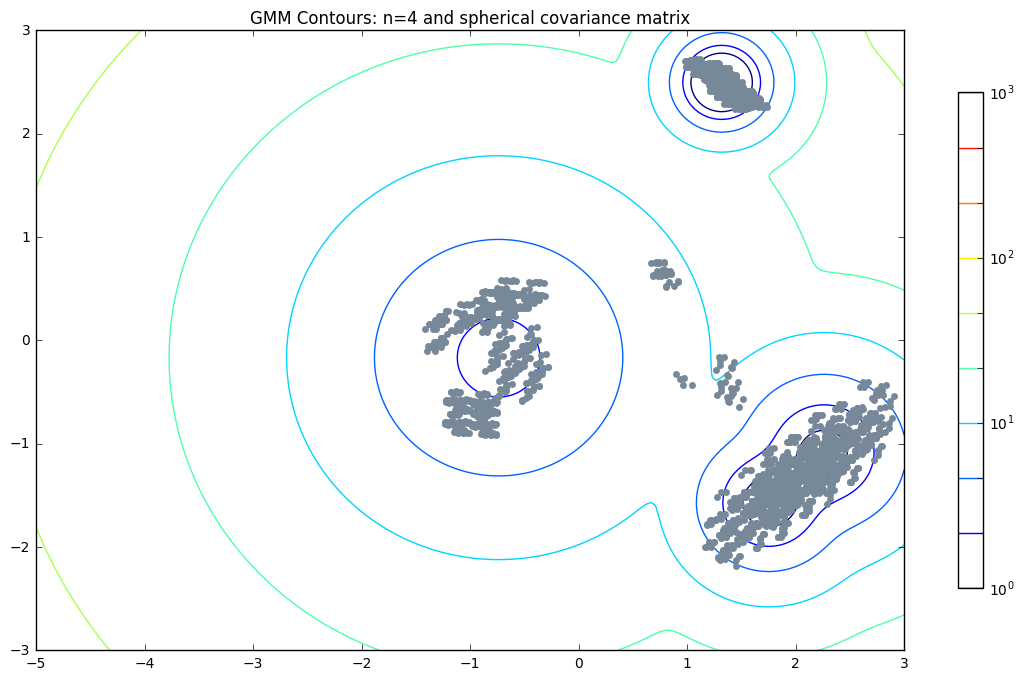

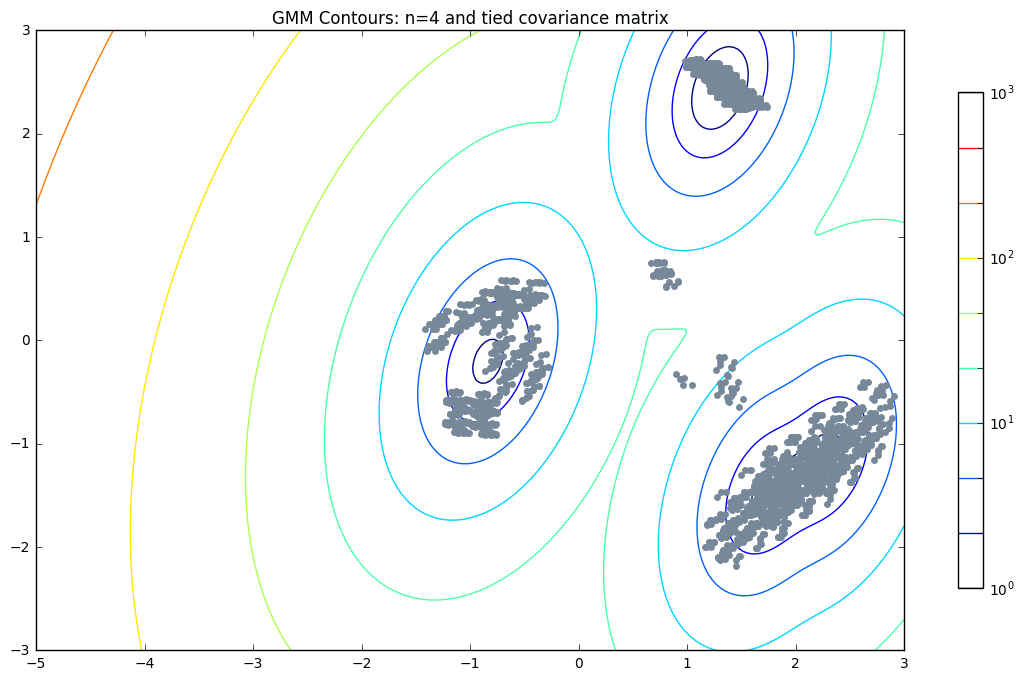

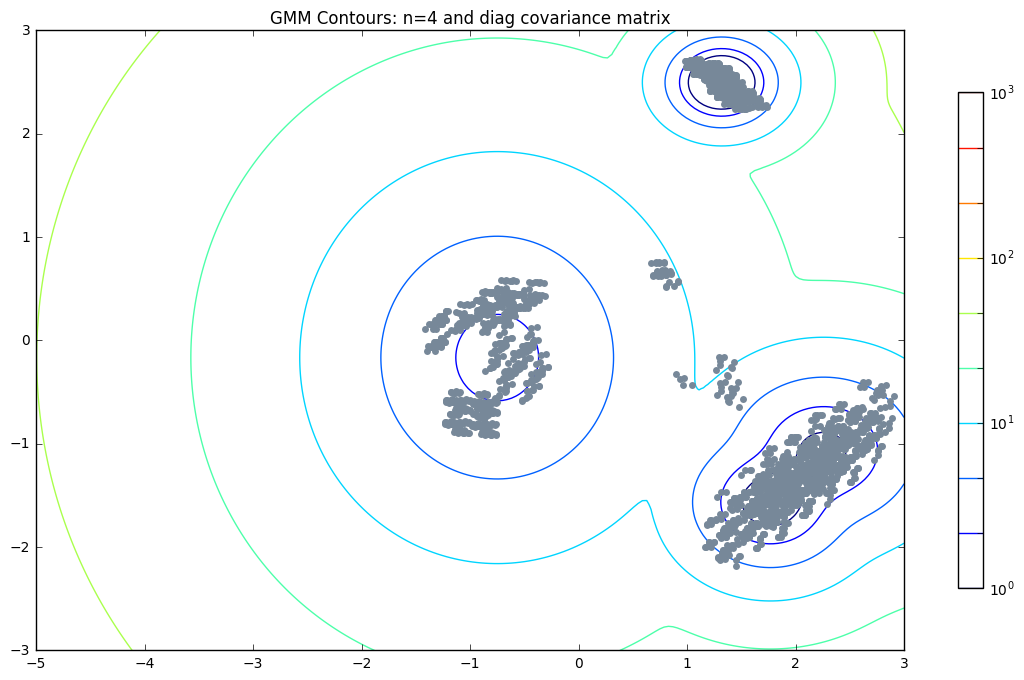

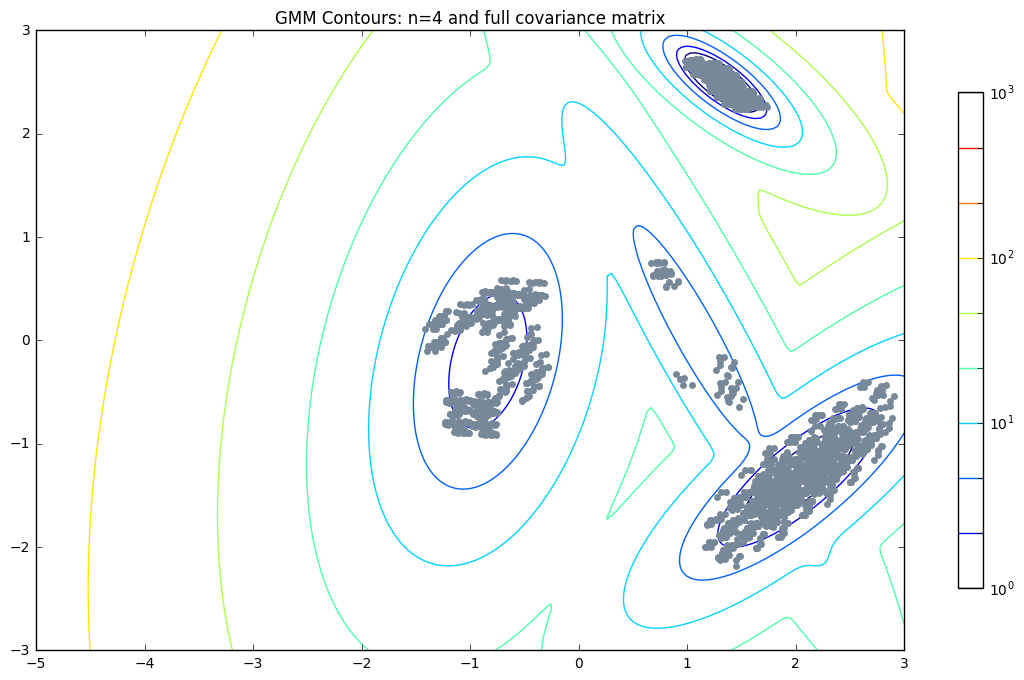

In [11]:
def P4():
    
### STUDENT START ###

    # Recreate 2d model 
    pca_2_mod = PCA(n_components=2)
    pca_2_mod_train = pca_2_mod.fit_transform(train_data)
    
    # Select only positives
    positives = pca_2_mod_train[train_labels==1]
    
    # Parameters to vary
    GMM_components = range(1,5)
    cov_types = ['spherical', 'tied', 'diag', 'full']
    
    # Iterate GMM components from 1-4 and covariance matrix types
    for component in GMM_components:
        for cov_index, cov in enumerate(cov_types):

            # Fit GMM
            gmm_model = GMM(n_components=component, covariance_type=cov)
            gmm_model.fit(positives)

            # Create meshgrid and calculate probabilities
            X1, X2 = np.meshgrid(np.linspace(-5.0, 3.0, 200), np.linspace(-3.0, 3.0, 200))
            XX = np.array([X1.ravel(), X2.ravel()]).T
            Z = -gmm_model.score_samples(XX)[0]
            Z = Z.reshape(X1.shape)
            
            # Plotting
            plt.figure(figsize = (14,8))
            plt.axis([-5,3,-3,3])
            CS = plt.contour(X1, X2, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')            
            plt.plot(positives[:, 0], positives[:, 1], color="LightSlateGray", ls='None', marker='o', markersize=5, markeredgewidth=0)
            plt.title('GMM Contours: ' + 'n=' + str(component) + ' and ' + cov + ' covariance matrix')

### STUDENT END ###
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [12]:
def P5():

### STUDENT START ###

    positive_data = pca_2_mod_train[train_labels==1,:]
    negative_data = pca_2_mod_train[train_labels==0,:]

    # Fit 4-component GMM models for Poisonous and Innocuos
    gmm_pos = GMM(n_components = 4, covariance_type='full')
    gmm_pos.fit(positive_data);

    gmm_neg = GMM(n_components = 4, covariance_type='full')
    gmm_neg.fit(negative_data);

    test_2d = pca_2_mod.transform(test_data)

    # Predicting output label
    predicted = (gmm_pos.score(test_2d) > gmm_neg.score(test_2d)).astype(np.uint8)

    accuracy = 1. * (predicted == test_labels).sum() / len(test_labels)

    print('Accuracy: {:.3%}'.format(accuracy))

### STUDENT END ###

P5()

Accuracy: 95.107%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [7]:
def P6():
    
### STUDENT START ###
    
    # 2 classes
    n_classes = 2
    
    # Initialize lists to store tested values
    params_tested = []
    accuracy_tested = []    
    
    # Iterate over PCA dimensions, covariance marix types, and GMM compnents
    
    for pca_components in range(1,51):
        for cov_type in ['spherical', 'tied', 'diag', 'full']:
            for gmm_components in range(1,51):
                # Get number of parameters for covariance matrix
                if cov_type == 'diag' or cov_type == 'spherical':
                    cov_components = pca_components
                elif cov_type == 'full':
                    cov_components = pca_components**2
                elif cov_type == 'tied':   
                    # all centers have same covariance matrix, divide each by number of clusters
                    cov_components = 1.0 * pca_components**2 / gmm_components
                # Obtain total number of parameters
                total_params = (pca_components + cov_components) * gmm_components * n_classes
                
                # Only run code if total number of parameters is less than 50
                if total_params > 50:
                    pass
                else:
                    # Append stored params lists
                    params_tested.append((pca_components, cov_type, gmm_components, total_params))

                    # Reduce train data and test data
                    pca_model = PCA(n_components=pca_components)
                    train_data_pca = pca_model.fit_transform(train_data)
                    test_data_pca = pca_model.transform(test_data)

                    # Select positive and negative training examples
                    positives = train_data_pca[train_labels==1]
                    negatives = train_data_pca[train_labels==0]

                    # Fitting GMM
                    gmm_model = GMM(n_components=gmm_components, covariance_type=cov_type)
                    # Fitting positive examples
                    gmm_model.fit(positives)
                    probs_positive = gmm_model.score(test_data_pca)
                    # Fitting negative examples
                    gmm_model.fit(negatives)
                    probs_negative = gmm_model.score(test_data_pca)

                    # Calculating prediction and accuracy
                    predictions = probs_positive > probs_negative
                    accuracy = 1.0 * sum(np.equal(predictions, test_labels)) / len(test_labels)
                    accuracy_tested.append(accuracy)

                    # Printing a some sample calculations
                    if pca_components < 3 and gmm_components < 3:
                        print (pca_components, cov_type, gmm_components, total_params, accuracy)
                
    max_index, max_accuracy= np.argmax(np.array(accuracy_tested)), np.amax(np.array(accuracy_tested))
    print ("... rest of calculations not printed")
    print ("Max accuracy is: {:.4f}.".format(max_accuracy))
    print ("The set of parameters associated is as follows:")
    print ("Number of PCA components: {}".format(params_tested[max_index][0]))
    print ("Covariance matrix type: {}".format(params_tested[max_index][1]))
    print ("Number of GMM components: {}".format(params_tested[max_index][2]))
                
### STUDENT END ###
P6()

1 spherical 1 4 0.844306049822
1 spherical 2 8 0.899466192171
1 tied 1 4.0 0.844306049822
1 tied 2 6.0 0.884341637011
1 diag 1 4 0.844306049822
1 diag 2 8 0.899466192171
1 full 1 4 0.844306049822
1 full 2 8 0.899466192171
2 spherical 1 8 0.860320284698
2 spherical 2 16 0.873665480427
2 tied 1 12.0 0.862099644128
2 tied 2 16.0 0.888790035587
2 diag 1 8 0.862099644128
2 diag 2 16 0.872775800712
2 full 1 12 0.862099644128
2 full 2 24 0.909252669039
... rest of calculations not printed
Max accuracy is: 0.9635.
The set of parameters associated is as follows:
Number of PCA components: 3
Covariance matrix type: tied
Number of GMM components: 3
